In [ ]:
!sudo apt-get install tree -qq > /dev/null

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


## Prerequisites

Let's start by installing some required libraries by the YOLOv5 project:

In [ ]:
!pip install torch==1.7.0+cu110 torchvision==0.8.1+cu110 torchaudio===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install numpy==1.19.2
!pip install PyYAML==5.3.1
!pip install git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████▌        | 834.1 MB 1.3 MB/s eta 0:04:02tcmalloc: large alloc 1147494400 bytes == 0x38cd4000 @  0x7f8d89bc9615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████████████████▊  | 1055.7 MB 1.3 MB/s eta 0:01:03tcmalloc: large alloc 1434370048 bytes == 0x7d32a000 @  0x7f8d89bc9615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 269 kB 4.8 MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44636 sha256=a022f96ee5d951f663730f277d8df893dba49bb40d35091ceb7d9ca61e0ac33c
  Stored in directory: /root/.cache/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653
Successfully built PyYAML
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-_404safa
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-_404safa
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=264612 sha256=ae0e927f407

In [ ]:
!git clone https://github.com/NVIDIA/apex && cd apex && pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" . --user && cd .. && rm -rf apex

## Build a dataset

Download the metadata from google drive

In [ ]:
!gdown --id 1P7E_zYBhNNCBnFcjclYCS0fBxIsqrIJU

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1P7E_zYBhNNCBnFcjclYCS0fBxIsqrIJU
To: /content/metadata.json
100% 15.5M/15.5M [00:00<00:00, 59.0MB/s]


The dataset contains a single JSON file

Let's import all required libraries:

In [ ]:
from pathlib import Path
import numpy as np
import json
import PIL.Image as Image
import cv2
import torch
import torchvision
import pandas as pd
import os
from IPython.display import display
from sklearn.model_selection import train_test_split

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

np.random.seed(42)

Turn json file into dataframe and transpose it so each image is in its own row

In [ ]:
df = pd.read_json('metadata.json')
df1 = df.T
res = 512 #set resolution

In [ ]:
datax =[] #create a list to be filled with all the maximum x values of the bounds
for j in range(0, len(df1)):
    xmax = 0
    for i in range(0, len(df1.iat[j,3])):
        if df1.iat[j,3][i]['x']>xmax:
            xmax = min(df1.iat[j,3][i]['x'],512)
    datax.append(xmax)

datay =[] #create a list to be filled with all the maximum y values of the bounds
for j in range(0, len(df1)):
    ymax = 0
    for i in range(0, len(df1.iat[j,3])):
        if df1.iat[j,3][i]['y']>ymax:
            ymax = min(df1.iat[j,3][i]['y'],512)
    datay.append(ymax)

datamx =[] #create a list to be filled with all the minumum x values of the bounds
for j in range(0, len(df1)):
    xmin = 1000
    for i in range(0, len(df1.iat[j,3])):
        if df1.iat[j,3][i]['x']<xmin:
            xmin = max(df1.iat[j,3][i]['x'],0)
    datamx.append(xmin)

datamy =[] #create a list to be filled with all the minumum x values of the bounds
for j in range(0, len(df1)):
    ymin = 1000
    for i in range(0, len(df1.iat[j,3])):
        if df1.iat[j,3][i]['y']<ymin:
            ymin = max(df1.iat[j,3][i]['y'],0)
    datamy.append(ymin)

box_bounds = [] #create a list of dictionaries with the 4 corners of the bounding box
for i in range (0, len(df1)):
    dict = [{'x':datax[i], 'y':datay[i]},{'x':datax[i], 'y':datamy[i]},{'x':datamx[i], 'y':datamy[i]},{'x':datamx[i], 'y':datay[i]}]
    box_bounds.append(dict) 
df1['box_bounds']=box_bounds

box_bounds_r = [] #create a list of dictionaries with the normalized version of the 4 corners of the bounding box
for i in range (0, len(df1)):
    dict_r = [{'x':datax[i]/res, 'y':datay[i]/res},{'x':datamx[i]/res, 'y':datamy[i]/res}]
    box_bounds_r.append(dict_r) 
df1['box_bounds_r']=box_bounds_r

In [ ]:
#yolo variables center_x and center_y
center_x = []
for i in range (0,len(df1)):
    cx= (datax[i]+datamx[i])/(2*res)
    center_x.append(cx)
df1['center_x']=center_x
    
center_y = []
for i in range (0,len(df1)):
    cy= (datay[i]+datamy[i])/(2*res)
    center_y.append(cy)   
df1['center_y']=center_y

#yolo variables heigth and width 
height = []
for i in range (0,len(df1)):
    h = (datax[i]-datamx[i])/res
    height.append(h)
df1['height']=height
width = []
for i in range(0,len(df1)):
    w = (datay[i]-datamy[i])/res
    width.append(w)
df1['width']=width

##Split data into train and test set

In [ ]:
train_pools, val_pools = train_test_split(df1, test_size=0.3)
len(train_pools), len(val_pools)

(10474, 4490)

### Sample image and annotation

Let's have a look at an image from the dataset. We'll start by downloading it:

In [ ]:
!gdown --id 1XIka-W7Kf-jDOPRicloGczYn8zZbsMIU #download images.zip from google drive

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1XIka-W7Kf-jDOPRicloGczYn8zZbsMIU
To: /content/images.zip
100% 4.02G/4.02G [00:37<00:00, 106MB/s]


In [ ]:
!unzip images.zip 

In [ ]:
images_name = os.listdir('/content/images')
images_name[0]

'43.4793477_-1.5401216.png'

In [ ]:
#choose image to view
a = 550

In [ ]:
# Test: open images
print('/content/images' +images_name[a])
img = cv2.imread('/content/images/' + images_name[a])

/content/images43.566936_1.6347258.png


We can use OpenCV to read the image:

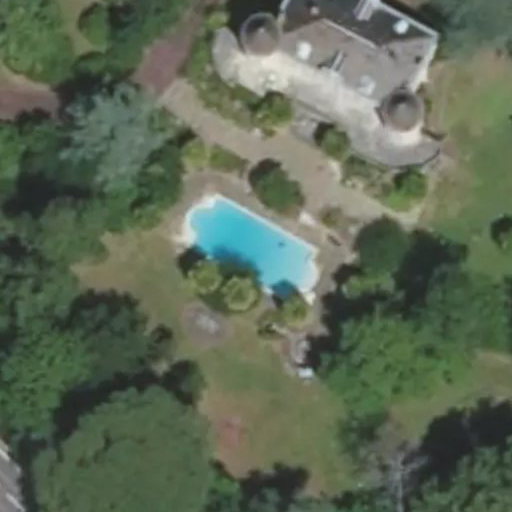

In [ ]:
# Test: Display images
from google.colab.patches import cv2_imshow
cv2_imshow(img)      # First argument = name of the window. Can put more
cv2.waitKey(0)               # Waits for a keeeeey!
cv2.destroyAllWindows()      # Close all windows (otherwise use cv2.destroyAllWindows(name of the window)

In [ ]:
pts =  [list((i["x"],i["y"])) for i in df1.loc[images_name[a]]["bounds_x_y"]]
pts = np.array(pts,np.int32)
pts = pts.reshape(-1,1,2)
print(pts)

cv2.polylines(img,[pts],True,(255,0,0));

[[[322 294]]

 [[322 189]]

 [[189 189]]

 [[189 294]]]


### Convert to YOLO format

YOLO v5 requires the dataset to be in the *darknet format*. Here's an outline of what it looks like:

- One txt with labels file per image
- One row per object
- Each row contains: `category_idx center_x center_y bbox_width bbox_height`
- Box coordinates must be normalized between 0 and 1

Let's create a helper function that builds a dataset in the correct format for us:

In [ ]:
def create_dataset(pools, dataset_type):

  images_path = Path(f"pools/images/{dataset_type}")
  images_path.mkdir(parents=True, exist_ok=True)

  labels_path = Path(f"pools/labels/{dataset_type}")
  labels_path.mkdir(parents=True, exist_ok=True)

  for i in range (0,len(pools)):
    image_name = f"{images_name[i]}"

    img = cv2.imread('/content/images/' + image_name)


    cv2.imwrite(os.path.join(images_path ,image_name), img)
    s= images_name[i]
    s=s.split(".png")[0]
    label_name = f"{s}.txt"

    with (labels_path / label_name).open(mode="w") as label_file:
      category_idx=0
      x_center = df1.loc[images_name[i]]['center_x']
      y_center = df1.loc[images_name[i]]['center_y']
      bbox_width = df1.loc[images_name[i]]['height']
      bbox_height = df1.loc[images_name[i]]['width']

      label_file.write(
      f"{category_idx} {x_center} {y_center} {bbox_width} {bbox_height}\n"
          )

In [ ]:
create_dataset(train_pools, 'train')
create_dataset(val_pools,  'val')

Since we copied the images to their designated directories, we can delete them at their original directory to conserve space

In [ ]:
%rm -rf '/content/images.zip'
%rm -rf '/content/images'

##Seting up training
Start by cloning the ultralytics repo and downloading some adapted configuration files. Pools.yaml for the data and yolov5l for the model

In [ ]:
!git clone https://github.com/ultralytics/yolov5

In [ ]:
!gdown --id 11C8rRKj1fCp-Dykn5ApXWF5W0krSMOk9 -O data/pools.yaml
!gdown --id 13U1FsbdHUBnCiPRklCUJIix6KIxlHZ9K -O models/yolov5l.yaml
#!gdown --id 1K0EGBsKQ0uFKCuUgu9CD5NT7fh9SkNiV yolovl5.pt we could get this to run without errors.


##Training YOLOv5

once this is finished we start downloading the best obtained weights and results for each epoch

In [ ]:
!python train.py --img 256 --batch 4 --epochs 20 \
  --data ./data/pools.yaml --cfg ./models/yolov5l.yaml --weights ""\
  --name yolov5l_pools --cache

In [ ]:
from google.colab import files
files.download('/content/yolov5/weights/best_yolov5l_pools.pt') 
files.download('/content/yolov5/results_yolov5l_pools.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Visualize results

Use the functions included in the github repo to visualize performance


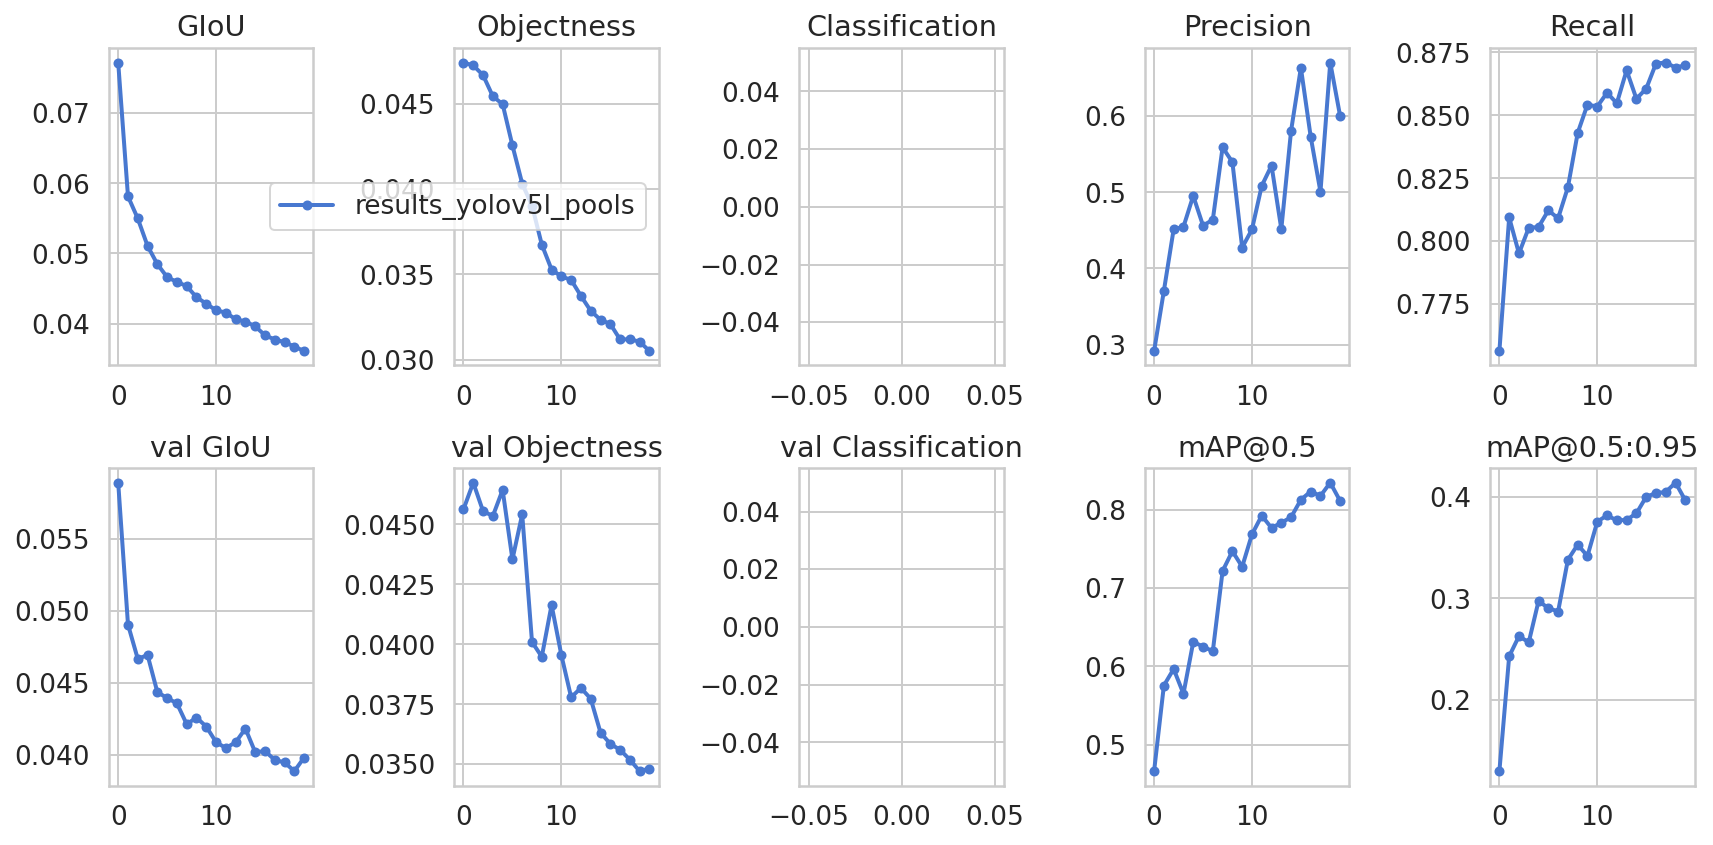

In [ ]:
from utils.utils import plot_results

plot_results();

##Visualize predictions

Move 100 images from the test set to a seperate directory and ask to model to make predictions for these images

In [ ]:
!find ../pools/images/val/ -maxdepth 1 -type f | head -100 | xargs cp -t "./inference/images/"

In [ ]:
!python detect.py --weights weights/best_yolov5l_pools.pt \
  --img 256 --conf 0.2 --source ./inference/images/

In [ ]:
def load_image(img_path: Path, resize=True):
  img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (128, 256), interpolation = cv2.INTER_AREA)
  return img

def show_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

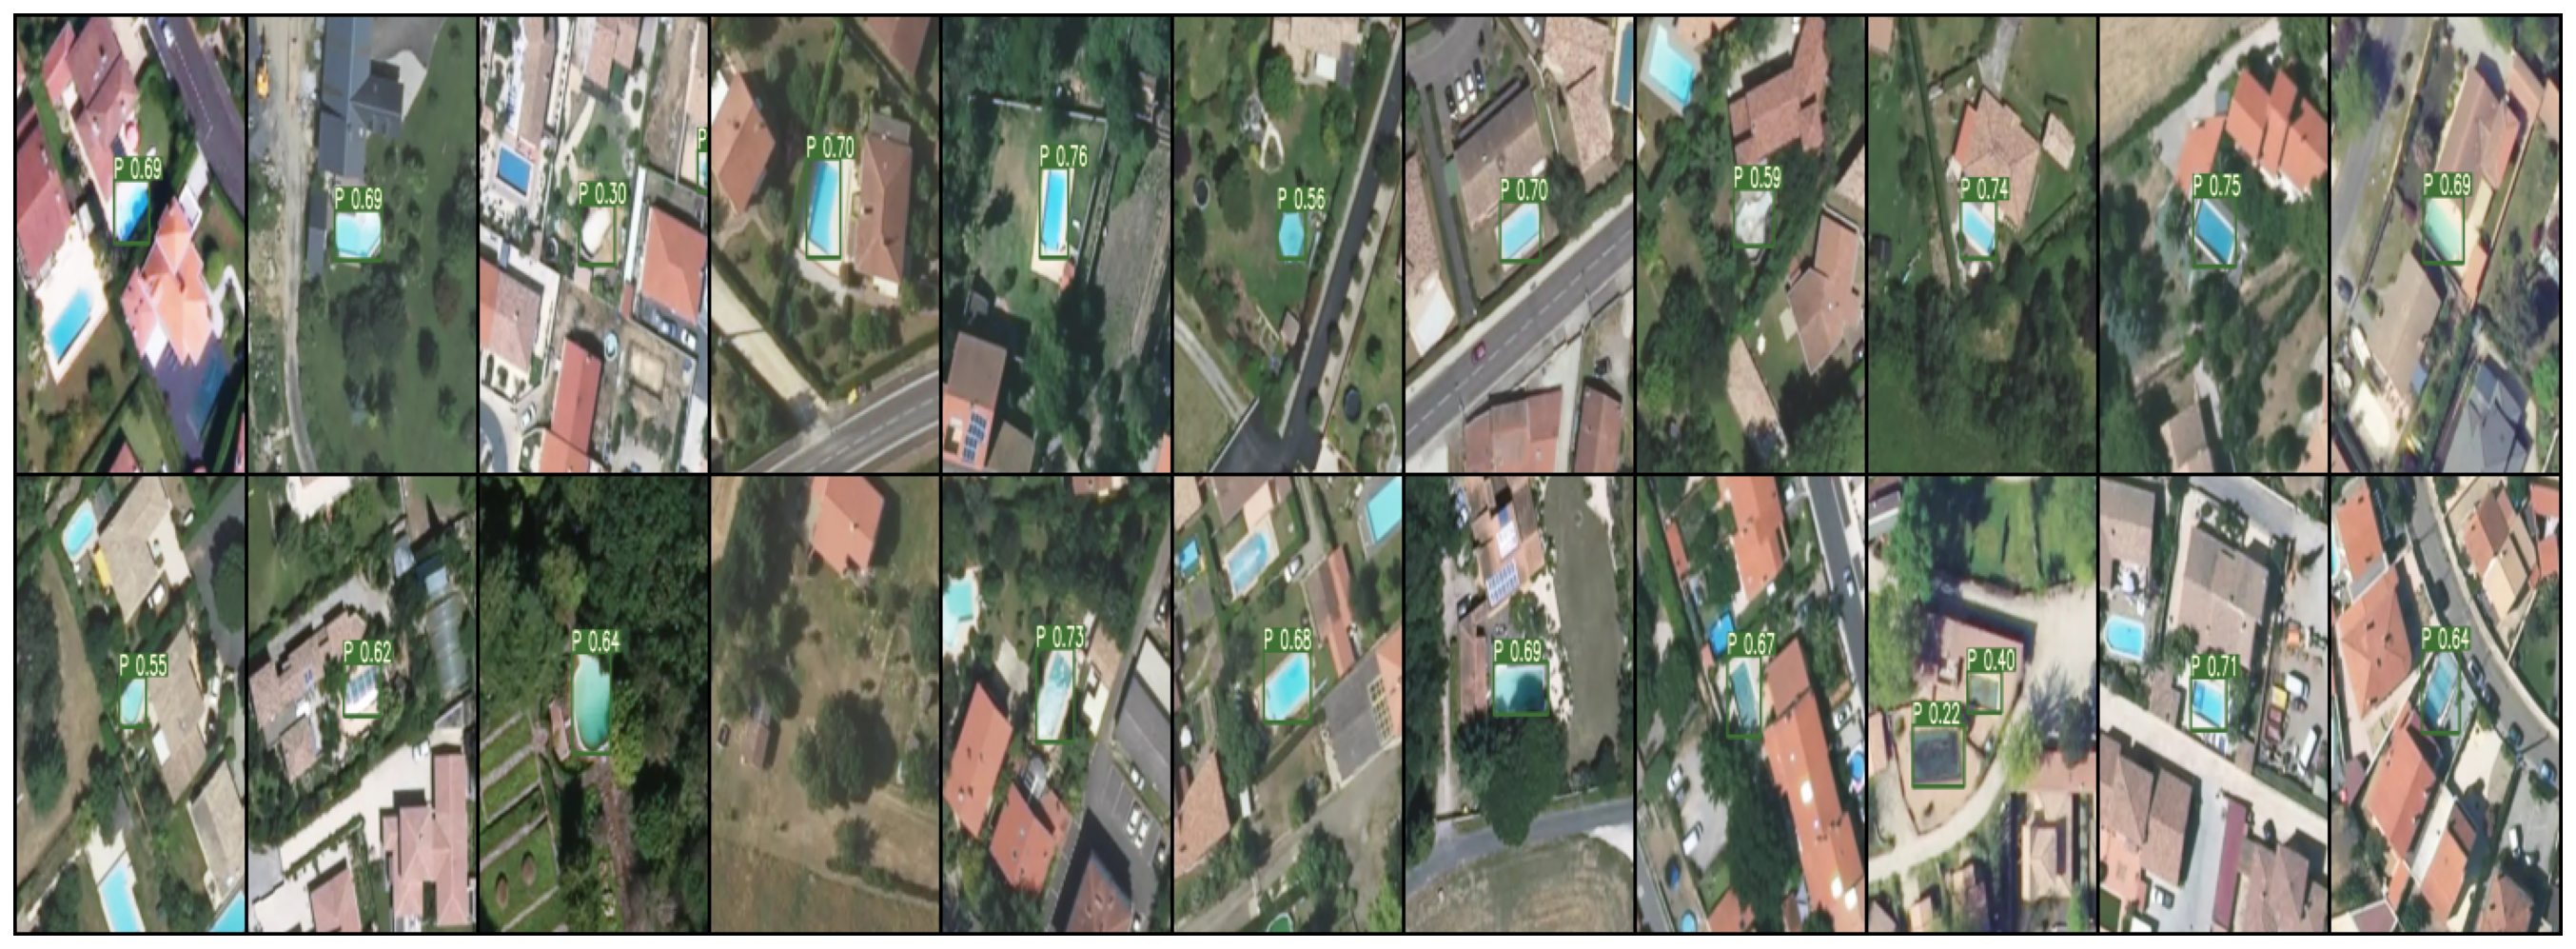

In [ ]:
img_paths = list(Path("inference/output").glob("*.png"))[:22]
show_grid(img_paths)

##Saving the images

Create a list with the names of all the images in inference so we can refer to them in the download loop.

In [ ]:
labelled =os.listdir('/content/yolov5/inference/output')
for i in range(0,len(labelled)):
  files.download('/content/yolov5/inference/output/'+str(labelled[i]))

## References

- [Clothing Item Detection for E-Commerce dataset](https://www.kaggle.com/dataturks/clothing-item-detection-for-ecommerce)
- [YOLOv5 GitHub](https://github.com/ultralytics/yolov5)
- [YOLOv5 Train on Custom Data](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data)
- [NVIDIA Apex on GitHub](https://github.com/NVIDIA/apex)
- [YOLOv4: Optimal Speed and Accuracy of Object Detection](https://arxiv.org/pdf/2004.10934.pdf)